# Machine learning and AI

In [1]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings("ignore")

### Reading data

In [2]:
el2022 = pd.read_csv('data/electricity-production and consumption_2022.csv',  delimiter=';',decimal=',')
el2022['timestamp'] = pd.to_datetime(el2022['Kuupaev (Eesti aeg)'], dayfirst=True)

consumption = el2022[['timestamp', 'Tarbimine']]
consumption.set_index('timestamp', inplace=True)
consumption = consumption.rename(columns = {'Tarbimine':'value'})
consumption.head()

,value
timestamp,
2022-01-01 00:00:00,899.4
2022-01-01 01:00:00,892.1
2022-01-01 02:00:00,874.3
2022-01-01 03:00:00,860.1
2022-01-01 04:00:00,842.7


## Lag features

In [3]:
consumption_lag7 = consumption[['value']].shift(24*7)
consumption_lag7 = consumption_lag7.rename(columns = {'value':'lag7'})
consumption = consumption.join(consumption_lag7)

consumption_lag2 = consumption[['value']].shift(24*2)
consumption_lag2 = consumption_lag2.rename(columns = {'value':'lag2'})
consumption = consumption.join(consumption_lag2)
consumption

,value,lag7,lag2
timestamp,,,
2022-01-01 00:00:00,899.4,NaN,NaN
2022-01-01 01:00:00,892.1,NaN,NaN
2022-01-01 02:00:00,874.3,NaN,NaN
2022-01-01 03:00:00,860.1,NaN,NaN
2022-01-01 04:00:00,842.7,NaN,NaN
...,...,...,...
2022-12-31 19:00:00,989.4,1009.5,1105.1
2022-12-31 20:00:00,932.5,982.7,1077.0
2022-12-31 21:00:00,889.5,965.4,1031.4


### Train/test split

In [4]:
predict_for_start = datetime.datetime(2022,10,6)
predict_for_end = predict_for_start + datetime.timedelta(days = 1)


validation_end=predict_for_start- datetime.timedelta(days = 1)
validation_start = validation_end- datetime.timedelta(days = 6)

training_end = predict_for_start - datetime.timedelta(days = 8)
training_start = training_end - datetime.timedelta(days = 30)

testing_vector = consumption[(consumption.index >= predict_for_start) &  (consumption.index < predict_for_end)]
training_vector = consumption[(consumption.index >= training_start) &  (consumption.index < training_end)]
validation_vector = consumption[(consumption.index >= validation_start) &  (consumption.index < validation_end)]


## Linear regression

### A single feature: lag7

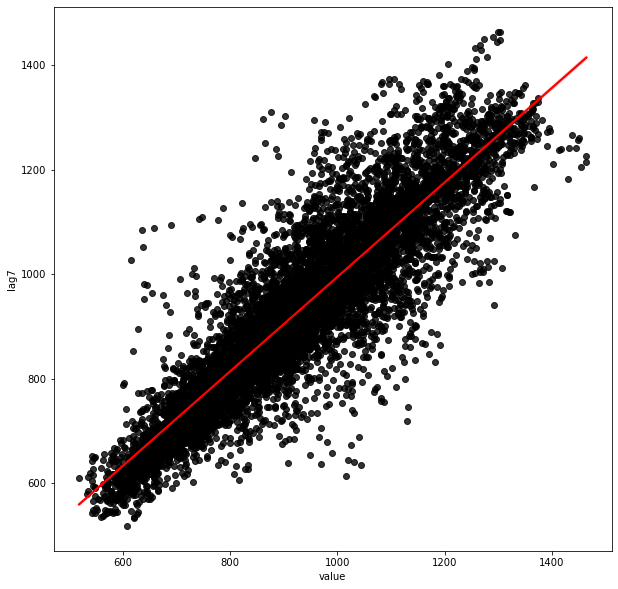

In [5]:
plt.figure(figsize=(10,10))
sns.regplot(x='value',y='lag7',data=consumption,  scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [6]:
X_test = testing_vector[['lag7']]
y_test = testing_vector[['value']]

X_valid = validation_vector[['lag7']]
y_valid = validation_vector[['value']]

X_train = training_vector[['lag7']]
y_train = training_vector[['value']]

MAPE: 4.834


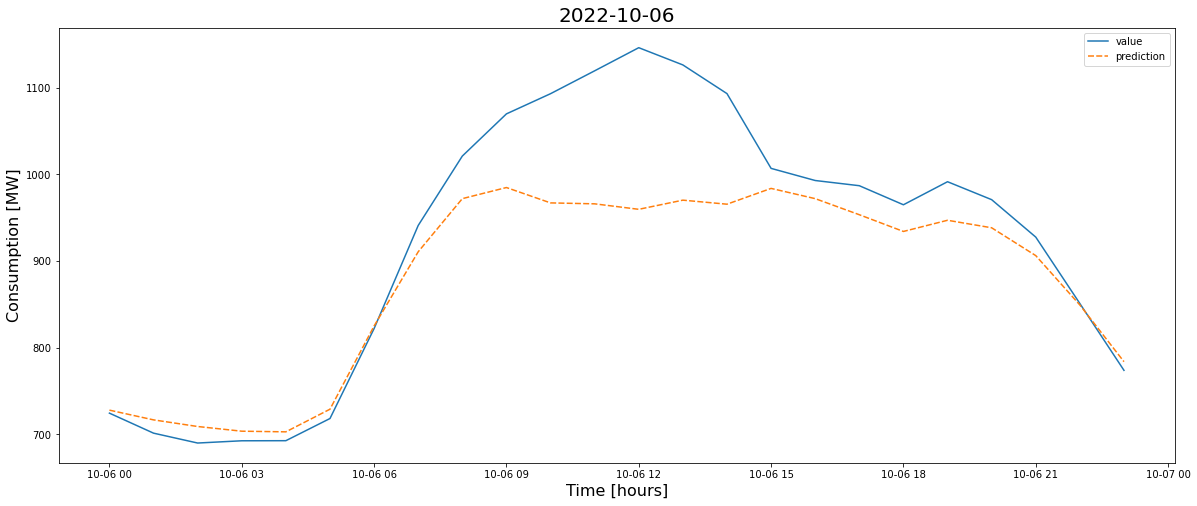

In [7]:
model = LinearRegression()
model.fit(X_train,y_train)

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title(predict_for_start.date(), fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions_vector)*100))

## Linear unit

In [128]:
from tensorflow import keras
from tensorflow.keras import layers

# Create a network with 1 linear unit
model = keras.Sequential([
    layers.Dense(units=1, input_shape=[1])
])

In [126]:
w, b = model.weights
print("Weights\n{}\n\nBias\n{}".format(w, b))

Weights
<tf.Variable 'dense_12/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.4587487]], dtype=float32)>

Bias
<tf.Variable 'dense_12/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


4/4 [==============================] - 0s 705us/step


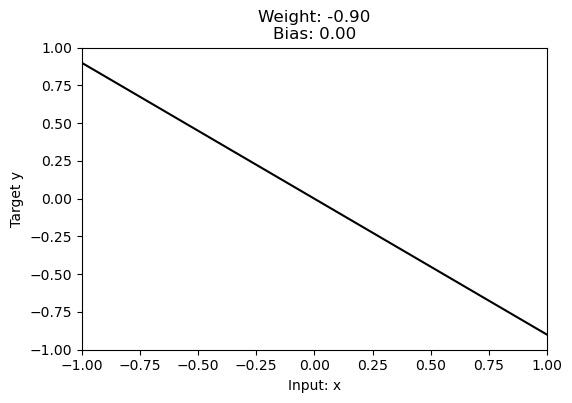

In [129]:
import tensorflow as tf
import matplotlib.pyplot as plt

model = keras.Sequential([
    layers.Dense(1, input_shape=[1]),
])

x = tf.linspace(-1.0, 1.0, 100)
y = model.predict(x)

plt.figure(dpi=100)
plt.plot(x, y, 'k')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Input: x")
plt.ylabel("Target y")
w, b = model.weights # you could also use model.get_weights() here
plt.title("Weight: {:0.2f}\nBias: {:0.2f}".format(w[0][0], b[0]))
plt.show()

In [12]:
model.compile(
    optimizer="adam",
    loss="mape",
)

In [23]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=200,
    epochs=20,
)

Epoch 1/20
4/4 [==============================] - 0s 13ms/step - loss: 5.0402 - val_loss: 4.8371
Epoch 2/20
4/4 [==============================] - 0s 5ms/step - loss: 5.0398 - val_loss: 4.8346
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 5.0397 - val_loss: 4.8322
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 5.0396 - val_loss: 4.8310
Epoch 5/20
4/4 [==============================] - 0s 5ms/step - loss: 5.0396 - val_loss: 4.8282
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 5.0396 - val_loss: 4.8260
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 5.0396 - val_loss: 4.8245
Epoch 8/20
4/4 [==============================] - 0s 5ms/step - loss: 5.0395 - val_loss: 4.8244
Epoch 9/20
4/4 [==============================] - 0s 6ms/step - loss: 5.0395 - val_loss: 4.8237
Epoch 10/20
4/4 [==============================] - 0s 5ms/step - loss: 5.0395 - val_loss: 4.8238
Epoch 11/20
4/4 [=====================

1/1 [==============================] - 0s 17ms/step
MAPE: 3.259


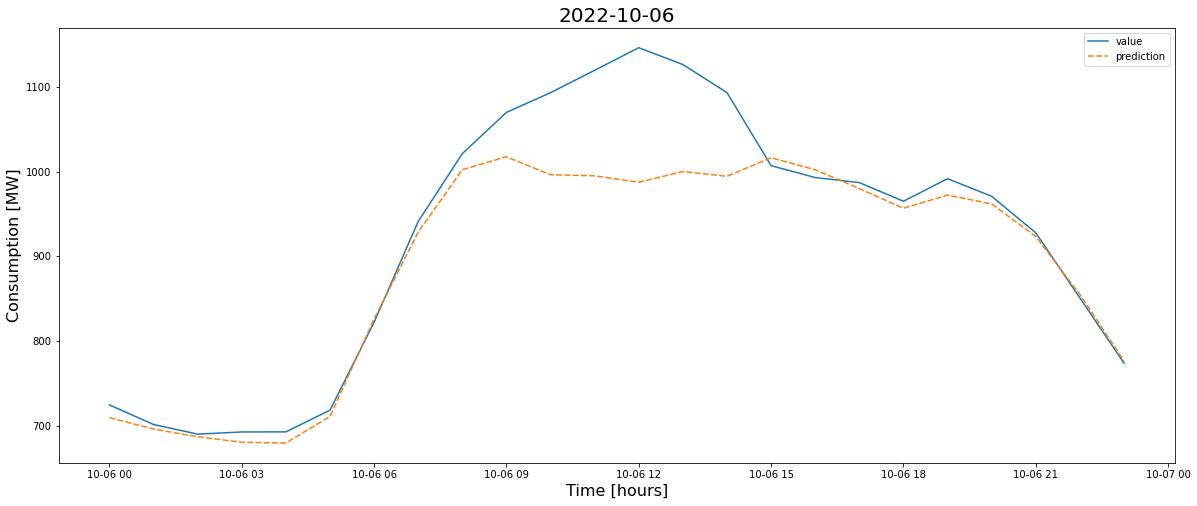

In [24]:
predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title(predict_for_start.date(), fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions_vector)*100))

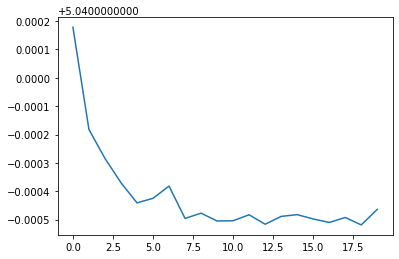

In [25]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();

## Adding more layers

In [26]:
consumption['ts'] = pd.to_datetime(consumption.index.values, dayfirst=True)
consumption['wd'] = consumption['ts'].dt.dayofweek
consumption['h'] = consumption['ts'].dt.hour
consumption

,value,lag7,lag2,ts,wd,h
timestamp,,,,,,
2022-01-01 00:00:00,899.4,NaN,NaN,2022-01-01 00:00:00,5,0
2022-01-01 01:00:00,892.1,NaN,NaN,2022-01-01 01:00:00,5,1
2022-01-01 02:00:00,874.3,NaN,NaN,2022-01-01 02:00:00,5,2
2022-01-01 03:00:00,860.1,NaN,NaN,2022-01-01 03:00:00,5,3
2022-01-01 04:00:00,842.7,NaN,NaN,2022-01-01 04:00:00,5,4
...,...,...,...,...,...,...
2022-12-31 19:00:00,989.4,1009.5,1105.1,2022-12-31 19:00:00,5,19
2022-12-31 20:00:00,932.5,982.7,1077.0,2022-12-31 20:00:00,5,20
2022-12-31 21:00:00,889.5,965.4,1031.4,2022-12-31 21:00:00,5,21


In [27]:
consumption['sin_wd'] = np.sin(consumption['wd'])
consumption['cos_wd'] = np.cos(consumption['wd'])
consumption['sin_h'] = np.sin(consumption['h'])
consumption['cos_h'] = np.cos(consumption['h'])


consumption

,value,lag7,lag2,ts,wd,h,sin_wd,cos_wd,sin_h,cos_h
timestamp,,,,,,,,,,
2022-01-01 00:00:00,899.4,NaN,NaN,2022-01-01 00:00:00,5,0,-0.958924,0.283662,0.000000,1.000000
2022-01-01 01:00:00,892.1,NaN,NaN,2022-01-01 01:00:00,5,1,-0.958924,0.283662,0.841471,0.540302
2022-01-01 02:00:00,874.3,NaN,NaN,2022-01-01 02:00:00,5,2,-0.958924,0.283662,0.909297,-0.416147
2022-01-01 03:00:00,860.1,NaN,NaN,2022-01-01 03:00:00,5,3,-0.958924,0.283662,0.141120,-0.989992
2022-01-01 04:00:00,842.7,NaN,NaN,2022-01-01 04:00:00,5,4,-0.958924,0.283662,-0.756802,-0.653644
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,989.4,1009.5,1105.1,2022-12-31 19:00:00,5,19,-0.958924,0.283662,0.149877,0.988705
2022-12-31 20:00:00,932.5,982.7,1077.0,2022-12-31 20:00:00,5,20,-0.958924,0.283662,0.912945,0.408082
2022-12-31 21:00:00,889.5,965.4,1031.4,2022-12-31 21:00:00,5,21,-0.958924,0.283662,0.836656,-0.547729


In [28]:
raw_weather = pd.read_csv('data/weather_2022.csv',  delimiter=';', decimal='.', index_col = False)
raw_weather['timestamp'] = pd.to_datetime(raw_weather['Local time in Tallinn (airport)'], dayfirst=True)
temperature = raw_weather[['timestamp', 'T']]
temperature.set_index('timestamp', inplace=True)
consumption = consumption.join(temperature)

consumption = consumption.reset_index().drop_duplicates(subset='timestamp', keep='last').set_index('timestamp')

consumption

,value,lag7,lag2,ts,wd,h,sin_wd,cos_wd,sin_h,cos_h,T
timestamp,,,,,,,,,,,
2022-01-01 00:00:00,899.4,NaN,NaN,2022-01-01 00:00:00,5,0,-0.958924,0.283662,0.000000,1.000000,-1.0
2022-01-01 01:00:00,892.1,NaN,NaN,2022-01-01 01:00:00,5,1,-0.958924,0.283662,0.841471,0.540302,-0.6
2022-01-01 02:00:00,874.3,NaN,NaN,2022-01-01 02:00:00,5,2,-0.958924,0.283662,0.909297,-0.416147,0.0
2022-01-01 03:00:00,860.1,NaN,NaN,2022-01-01 03:00:00,5,3,-0.958924,0.283662,0.141120,-0.989992,-0.1
2022-01-01 04:00:00,842.7,NaN,NaN,2022-01-01 04:00:00,5,4,-0.958924,0.283662,-0.756802,-0.653644,-0.1
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,989.4,1009.5,1105.1,2022-12-31 19:00:00,5,19,-0.958924,0.283662,0.149877,0.988705,5.4
2022-12-31 20:00:00,932.5,982.7,1077.0,2022-12-31 20:00:00,5,20,-0.958924,0.283662,0.912945,0.408082,5.7
2022-12-31 21:00:00,889.5,965.4,1031.4,2022-12-31 21:00:00,5,21,-0.958924,0.283662,0.836656,-0.547729,5.8


In [29]:
testing_vector = consumption[(consumption.index >= predict_for_start) &  (consumption.index < predict_for_end)]
training_vector = consumption[(consumption.index >= training_start) &  (consumption.index < training_end)]
validation_vector = consumption[(consumption.index >= validation_start) &  (consumption.index < validation_end)]


X_test = testing_vector[['lag7','lag2']]
y_test = testing_vector[['value']]

X_valid = validation_vector[['lag7','lag2']]
y_valid = validation_vector[['value']]

X_train = training_vector[['lag7','lag2']]
y_train = training_vector[['value']]

X_test 

,lag7,lag2
timestamp,,
2022-10-06 00:00:00,710.5,747.7
2022-10-06 01:00:00,697.0,728.5
2022-10-06 02:00:00,687.8,716.2
2022-10-06 03:00:00,681.3,711.1
2022-10-06 04:00:00,680.4,708.7
2022-10-06 05:00:00,711.8,739.9
2022-10-06 06:00:00,827.2,859.2
2022-10-06 07:00:00,930.1,974.9
2022-10-06 08:00:00,1003.8,1052.3


In [71]:
model = keras.Sequential([
    # the hidden layers
    layers.Dense(units=4, activation='relu', input_shape=[2]),
    layers.Dense(units=2, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1),
])

In [78]:
model.compile(
    optimizer="adam",
    loss="mape",
)

In [114]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=1000,
    epochs=20
)


Epoch 1/20
1/1 [==============================] - 0s 34ms/step - loss: 4.6960 - val_loss: 5.6366
Epoch 2/20
1/1 [==============================] - 0s 15ms/step - loss: 4.6957 - val_loss: 5.6415
Epoch 3/20
1/1 [==============================] - 0s 16ms/step - loss: 4.6955 - val_loss: 5.6464
Epoch 4/20
1/1 [==============================] - 0s 16ms/step - loss: 4.6953 - val_loss: 5.6511
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 4.6951 - val_loss: 5.6557
Epoch 6/20
1/1 [==============================] - 0s 16ms/step - loss: 4.6950 - val_loss: 5.6598
Epoch 7/20
1/1 [==============================] - 0s 15ms/step - loss: 4.6948 - val_loss: 5.6636
Epoch 8/20
1/1 [==============================] - 0s 16ms/step - loss: 4.6947 - val_loss: 5.6672
Epoch 9/20
1/1 [==============================] - 0s 15ms/step - loss: 4.6946 - val_loss: 5.6705
Epoch 10/20
1/1 [==============================] - 0s 15ms/step - loss: 4.6944 - val_loss: 5.6734
Epoch 11/20
1/1 [============

1/1 [==============================] - 0s 16ms/step
MAPE: 3.129


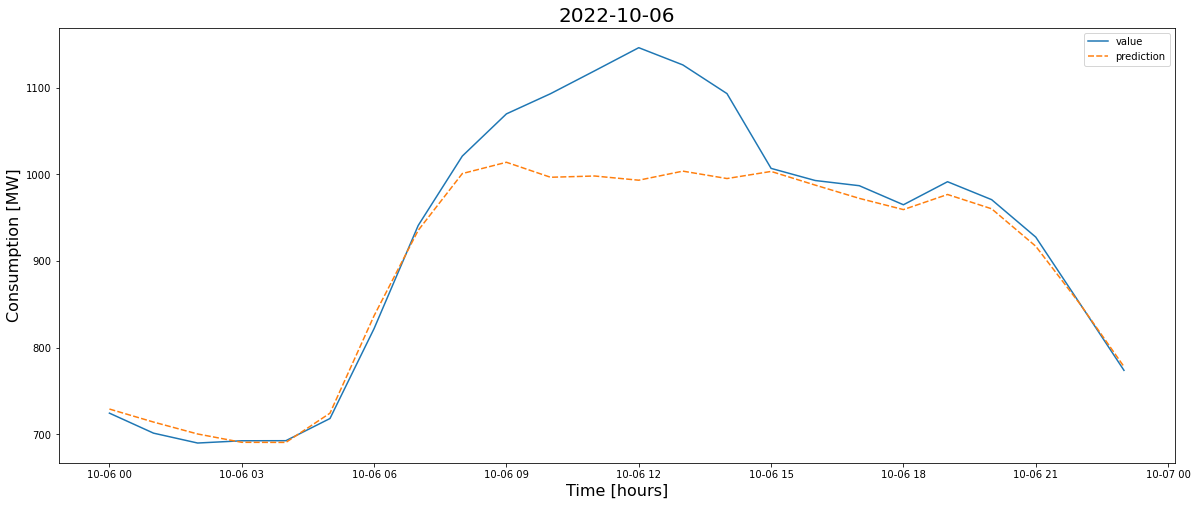

In [115]:
predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title(predict_for_start.date(), fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions_vector)*100))

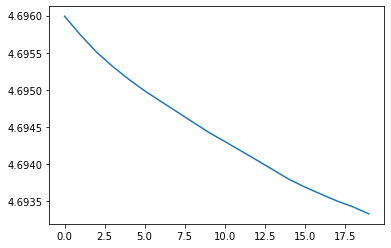

In [116]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();

In [82]:
from sklearn.preprocessing import minmax_scale

consumption[['lag7_sc','lag2_sc','T_sc']] = minmax_scale(consumption[['lag7','lag2','T']])
consumption

,value,lag7,lag2,ts,wd,h,sin_wd,cos_wd,sin_h,cos_h,T,lag7_sc,lag2_sc,T_sc
timestamp,,,,,,,,,,,,,,
2022-01-01 00:00:00,899.4,NaN,NaN,2022-01-01 00:00:00,5,0,-0.958924,0.283662,0.000000,1.000000,-1.0,NaN,NaN,0.322382
2022-01-01 01:00:00,892.1,NaN,NaN,2022-01-01 01:00:00,5,1,-0.958924,0.283662,0.841471,0.540302,-0.6,NaN,NaN,0.330595
2022-01-01 02:00:00,874.3,NaN,NaN,2022-01-01 02:00:00,5,2,-0.958924,0.283662,0.909297,-0.416147,0.0,NaN,NaN,0.342916
2022-01-01 03:00:00,860.1,NaN,NaN,2022-01-01 03:00:00,5,3,-0.958924,0.283662,0.141120,-0.989992,-0.1,NaN,NaN,0.340862
2022-01-01 04:00:00,842.7,NaN,NaN,2022-01-01 04:00:00,5,4,-0.958924,0.283662,-0.756802,-0.653644,-0.1,NaN,NaN,0.340862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,989.4,1009.5,1105.1,2022-12-31 19:00:00,5,19,-0.958924,0.283662,0.149877,0.988705,5.4,0.519446,0.620482,0.453799
2022-12-31 20:00:00,932.5,982.7,1077.0,2022-12-31 20:00:00,5,20,-0.958924,0.283662,0.912945,0.408082,5.7,0.491122,0.590784,0.459959
2022-12-31 21:00:00,889.5,965.4,1031.4,2022-12-31 21:00:00,5,21,-0.958924,0.283662,0.836656,-0.547729,5.8,0.472839,0.542591,0.462012


In [139]:
testing_vector = consumption[(consumption.index >= predict_for_start) &  (consumption.index < predict_for_end)]
training_vector = consumption[(consumption.index >= training_start) &  (consumption.index < training_end)]
validation_vector = consumption[(consumption.index >= validation_start) &  (consumption.index < validation_end)]


X_test = testing_vector[['lag7_sc','lag2_sc','sin_wd','cos_wd','sin_h','cos_h','T_sc']]
y_test = testing_vector[['value']]

X_valid = validation_vector[['lag7_sc','lag2_sc','sin_wd','cos_wd','sin_h','cos_h','T_sc']]
y_valid = validation_vector[['value']]

X_train = training_vector[['lag7_sc','lag2_sc','sin_wd','cos_wd','sin_h','cos_h','T_sc']]
y_train = training_vector[['value']]
X_test

,lag7_sc,lag2_sc,sin_wd,cos_wd,sin_h,cos_h,T_sc
timestamp,,,,,,,
2022-10-06 00:00:00,0.203445,0.242761,0.14112,-0.989992,0.000000,1.000000,0.618070
2022-10-06 01:00:00,0.189178,0.222469,0.14112,-0.989992,0.841471,0.540302,0.620123
2022-10-06 02:00:00,0.179455,0.209469,0.14112,-0.989992,0.909297,-0.416147,0.618070
2022-10-06 03:00:00,0.172585,0.204079,0.14112,-0.989992,0.141120,-0.989992,0.609856
2022-10-06 04:00:00,0.171634,0.201543,0.14112,-0.989992,-0.756802,-0.653644,0.616016
2022-10-06 05:00:00,0.204819,0.234517,0.14112,-0.989992,-0.958924,0.283662,0.620123
2022-10-06 06:00:00,0.326781,0.360600,0.14112,-0.989992,-0.279415,0.960170,0.622177
2022-10-06 07:00:00,0.435532,0.482879,0.14112,-0.989992,0.656987,0.753902,0.622177
2022-10-06 08:00:00,0.513422,0.564680,0.14112,-0.989992,0.989358,-0.145500,0.620123


In [140]:
model = keras.Sequential([
    # the hidden layers
    layers.Dense(units=8, activation='relu', input_shape=[7]),
    layers.Dense(units=4, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1),
])

In [141]:
model.compile(
    optimizer="adam",
    loss="mape",
)

In [144]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=1000,
    epochs=2000,
)


Epoch 1/2000
1/1 [==============================] - 0s 39ms/step - loss: 95.3671 - val_loss: 95.6147
Epoch 2/2000
1/1 [==============================] - 0s 16ms/step - loss: 95.3355 - val_loss: 95.5845
Epoch 3/2000
1/1 [==============================] - 0s 16ms/step - loss: 95.3038 - val_loss: 95.5541
Epoch 4/2000
1/1 [==============================] - 0s 17ms/step - loss: 95.2719 - val_loss: 95.5236
Epoch 5/2000
1/1 [==============================] - 0s 15ms/step - loss: 95.2398 - val_loss: 95.4929
Epoch 6/2000
1/1 [==============================] - 0s 17ms/step - loss: 95.2076 - val_loss: 95.4620
Epoch 7/2000
1/1 [==============================] - 0s 16ms/step - loss: 95.1752 - val_loss: 95.4310
Epoch 8/2000
1/1 [==============================] - 0s 17ms/step - loss: 95.1427 - val_loss: 95.3998
Epoch 9/2000
1/1 [==============================] - 0s 17ms/step - loss: 95.1100 - val_loss: 95.3685
Epoch 10/2000
1/1 [==============================] - 0s 17ms/step - loss: 95.0771 - val_los

1/1 [==============================] - 0s 16ms/step - loss: 92.3172 - val_loss: 92.6836
Epoch 82/2000
1/1 [==============================] - 0s 15ms/step - loss: 92.2721 - val_loss: 92.6400
Epoch 83/2000
1/1 [==============================] - 0s 16ms/step - loss: 92.2268 - val_loss: 92.5963
Epoch 84/2000
1/1 [==============================] - 0s 15ms/step - loss: 92.1813 - val_loss: 92.5524
Epoch 85/2000
1/1 [==============================] - 0s 15ms/step - loss: 92.1357 - val_loss: 92.5083
Epoch 86/2000
1/1 [==============================] - 0s 15ms/step - loss: 92.0898 - val_loss: 92.4640
Epoch 87/2000
1/1 [==============================] - 0s 15ms/step - loss: 92.0438 - val_loss: 92.4196
Epoch 88/2000
1/1 [==============================] - 0s 15ms/step - loss: 91.9976 - val_loss: 92.3750
Epoch 89/2000
1/1 [==============================] - 0s 15ms/step - loss: 91.9512 - val_loss: 92.3302
Epoch 90/2000
1/1 [==============================] - 0s 15ms/step - loss: 91.9047 - val_loss: 92

Epoch 161/2000
1/1 [==============================] - 0s 16ms/step - loss: 88.1218 - val_loss: 88.6229
Epoch 162/2000
1/1 [==============================] - 0s 16ms/step - loss: 88.0616 - val_loss: 88.5644
Epoch 163/2000
1/1 [==============================] - 0s 15ms/step - loss: 88.0012 - val_loss: 88.5057
Epoch 164/2000
1/1 [==============================] - 0s 15ms/step - loss: 87.9406 - val_loss: 88.4469
Epoch 165/2000
1/1 [==============================] - 0s 16ms/step - loss: 87.8798 - val_loss: 88.3878
Epoch 166/2000
1/1 [==============================] - 0s 16ms/step - loss: 87.8188 - val_loss: 88.3285
Epoch 167/2000
1/1 [==============================] - 0s 16ms/step - loss: 87.7576 - val_loss: 88.2690
Epoch 168/2000
1/1 [==============================] - 0s 16ms/step - loss: 87.6962 - val_loss: 88.2093
Epoch 169/2000
1/1 [==============================] - 0s 15ms/step - loss: 87.6346 - val_loss: 88.1495
Epoch 170/2000
1/1 [==============================] - 0s 14ms/step - loss

1/1 [==============================] - 0s 17ms/step - loss: 82.7422 - val_loss: 83.3858
Epoch 241/2000
1/1 [==============================] - 0s 16ms/step - loss: 82.6658 - val_loss: 83.3113
Epoch 242/2000
1/1 [==============================] - 0s 16ms/step - loss: 82.5891 - val_loss: 83.2365
Epoch 243/2000
1/1 [==============================] - 0s 16ms/step - loss: 82.5123 - val_loss: 83.1616
Epoch 244/2000
1/1 [==============================] - 0s 16ms/step - loss: 82.4352 - val_loss: 83.0864
Epoch 245/2000
1/1 [==============================] - 0s 16ms/step - loss: 82.3580 - val_loss: 83.0110
Epoch 246/2000
1/1 [==============================] - 0s 17ms/step - loss: 82.2805 - val_loss: 82.9354
Epoch 247/2000
1/1 [==============================] - 0s 18ms/step - loss: 82.2028 - val_loss: 82.8596
Epoch 248/2000
1/1 [==============================] - 0s 16ms/step - loss: 82.1249 - val_loss: 82.7836
Epoch 249/2000
1/1 [==============================] - 0s 15ms/step - loss: 82.0467 - val

1/1 [==============================] - 0s 15ms/step - loss: 76.0297 - val_loss: 76.8309
Epoch 320/2000
1/1 [==============================] - 0s 15ms/step - loss: 75.9357 - val_loss: 76.7390
Epoch 321/2000
1/1 [==============================] - 0s 15ms/step - loss: 75.8415 - val_loss: 76.6469
Epoch 322/2000
1/1 [==============================] - 0s 15ms/step - loss: 75.7470 - val_loss: 76.5546
Epoch 323/2000
1/1 [==============================] - 0s 16ms/step - loss: 75.6524 - val_loss: 76.4620
Epoch 324/2000
1/1 [==============================] - 0s 15ms/step - loss: 75.5575 - val_loss: 76.3692
Epoch 325/2000
1/1 [==============================] - 0s 15ms/step - loss: 75.4624 - val_loss: 76.2762
Epoch 326/2000
1/1 [==============================] - 0s 15ms/step - loss: 75.3670 - val_loss: 76.1829
Epoch 327/2000
1/1 [==============================] - 0s 15ms/step - loss: 75.2714 - val_loss: 76.0894
Epoch 328/2000
1/1 [==============================] - 0s 16ms/step - loss: 75.1756 - val

1/1 [==============================] - 0s 16ms/step - loss: 67.8786 - val_loss: 68.8487
Epoch 399/2000
1/1 [==============================] - 0s 15ms/step - loss: 67.7658 - val_loss: 68.7381
Epoch 400/2000
1/1 [==============================] - 0s 15ms/step - loss: 67.6527 - val_loss: 68.6272
Epoch 401/2000
1/1 [==============================] - 0s 15ms/step - loss: 67.5394 - val_loss: 68.5161
Epoch 402/2000
1/1 [==============================] - 0s 15ms/step - loss: 67.4259 - val_loss: 68.4047
Epoch 403/2000
1/1 [==============================] - 0s 15ms/step - loss: 67.3121 - val_loss: 68.2931
Epoch 404/2000
1/1 [==============================] - 0s 14ms/step - loss: 67.1981 - val_loss: 68.1813
Epoch 405/2000
1/1 [==============================] - 0s 15ms/step - loss: 67.0838 - val_loss: 68.0692
Epoch 406/2000
1/1 [==============================] - 0s 15ms/step - loss: 66.9693 - val_loss: 67.9569
Epoch 407/2000
1/1 [==============================] - 0s 16ms/step - loss: 66.8545 - val

1/1 [==============================] - 0s 15ms/step - loss: 58.1995 - val_loss: 59.3434
Epoch 478/2000
1/1 [==============================] - 0s 15ms/step - loss: 58.0668 - val_loss: 59.2129
Epoch 479/2000
1/1 [==============================] - 0s 16ms/step - loss: 57.9339 - val_loss: 59.0822
Epoch 480/2000
1/1 [==============================] - 0s 15ms/step - loss: 57.8007 - val_loss: 58.9512
Epoch 481/2000
1/1 [==============================] - 0s 15ms/step - loss: 57.6672 - val_loss: 58.8200
Epoch 482/2000
1/1 [==============================] - 0s 15ms/step - loss: 57.5335 - val_loss: 58.6885
Epoch 483/2000
1/1 [==============================] - 0s 16ms/step - loss: 57.3995 - val_loss: 58.5567
Epoch 484/2000
1/1 [==============================] - 0s 15ms/step - loss: 57.2653 - val_loss: 58.4247
Epoch 485/2000
1/1 [==============================] - 0s 15ms/step - loss: 57.1308 - val_loss: 58.2925
Epoch 486/2000
1/1 [==============================] - 0s 15ms/step - loss: 56.9960 - val

1/1 [==============================] - 0s 15ms/step - loss: 46.9073 - val_loss: 48.2298
Epoch 557/2000
1/1 [==============================] - 0s 15ms/step - loss: 46.7537 - val_loss: 48.0785
Epoch 558/2000
1/1 [==============================] - 0s 15ms/step - loss: 46.5998 - val_loss: 47.9269
Epoch 559/2000
1/1 [==============================] - 0s 15ms/step - loss: 46.4457 - val_loss: 47.7750
Epoch 560/2000
1/1 [==============================] - 0s 14ms/step - loss: 46.2912 - val_loss: 47.6228
Epoch 561/2000
1/1 [==============================] - 0s 15ms/step - loss: 46.1365 - val_loss: 47.4704
Epoch 562/2000
1/1 [==============================] - 0s 15ms/step - loss: 45.9816 - val_loss: 47.3177
Epoch 563/2000
1/1 [==============================] - 0s 15ms/step - loss: 45.8263 - val_loss: 47.1648
Epoch 564/2000
1/1 [==============================] - 0s 14ms/step - loss: 45.6708 - val_loss: 47.0116
Epoch 565/2000
1/1 [==============================] - 0s 15ms/step - loss: 45.5150 - val

1/1 [==============================] - 0s 15ms/step - loss: 35.1323 - val_loss: 36.4033
Epoch 636/2000
1/1 [==============================] - 0s 16ms/step - loss: 35.0028 - val_loss: 36.2793
Epoch 637/2000
1/1 [==============================] - 0s 15ms/step - loss: 34.8739 - val_loss: 36.1556
Epoch 638/2000
1/1 [==============================] - 0s 15ms/step - loss: 34.7453 - val_loss: 36.0334
Epoch 639/2000
1/1 [==============================] - 0s 15ms/step - loss: 34.6169 - val_loss: 35.9130
Epoch 640/2000
1/1 [==============================] - 0s 15ms/step - loss: 34.4889 - val_loss: 35.7929
Epoch 641/2000
1/1 [==============================] - 0s 15ms/step - loss: 34.3615 - val_loss: 35.6731
Epoch 642/2000
1/1 [==============================] - 0s 16ms/step - loss: 34.2346 - val_loss: 35.5534
Epoch 643/2000
1/1 [==============================] - 0s 15ms/step - loss: 34.1078 - val_loss: 35.4339
Epoch 644/2000
1/1 [==============================] - 0s 15ms/step - loss: 33.9816 - val

1/1 [==============================] - 0s 15ms/step - loss: 26.3673 - val_loss: 28.2098
Epoch 715/2000
1/1 [==============================] - 0s 16ms/step - loss: 26.2763 - val_loss: 28.1292
Epoch 716/2000
1/1 [==============================] - 0s 16ms/step - loss: 26.1856 - val_loss: 28.0500
Epoch 717/2000
1/1 [==============================] - 0s 16ms/step - loss: 26.0951 - val_loss: 27.9710
Epoch 718/2000
1/1 [==============================] - 0s 15ms/step - loss: 26.0047 - val_loss: 27.8922
Epoch 719/2000
1/1 [==============================] - 0s 15ms/step - loss: 25.9150 - val_loss: 27.8136
Epoch 720/2000
1/1 [==============================] - 0s 15ms/step - loss: 25.8262 - val_loss: 27.7351
Epoch 721/2000
1/1 [==============================] - 0s 14ms/step - loss: 25.7381 - val_loss: 27.6568
Epoch 722/2000
1/1 [==============================] - 0s 15ms/step - loss: 25.6501 - val_loss: 27.5786
Epoch 723/2000
1/1 [==============================] - 0s 15ms/step - loss: 25.5624 - val

1/1 [==============================] - 0s 14ms/step - loss: 20.4789 - val_loss: 22.9564
Epoch 794/2000
1/1 [==============================] - 0s 15ms/step - loss: 20.4201 - val_loss: 22.9040
Epoch 795/2000
1/1 [==============================] - 0s 15ms/step - loss: 20.3621 - val_loss: 22.8517
Epoch 796/2000
1/1 [==============================] - 0s 15ms/step - loss: 20.3042 - val_loss: 22.7996
Epoch 797/2000
1/1 [==============================] - 0s 15ms/step - loss: 20.2465 - val_loss: 22.7477
Epoch 798/2000
1/1 [==============================] - 0s 15ms/step - loss: 20.1890 - val_loss: 22.6961
Epoch 799/2000
1/1 [==============================] - 0s 15ms/step - loss: 20.1317 - val_loss: 22.6445
Epoch 800/2000
1/1 [==============================] - 0s 15ms/step - loss: 20.0745 - val_loss: 22.5931
Epoch 801/2000
1/1 [==============================] - 0s 15ms/step - loss: 20.0175 - val_loss: 22.5418
Epoch 802/2000
1/1 [==============================] - 0s 15ms/step - loss: 19.9605 - val

1/1 [==============================] - 0s 15ms/step - loss: 16.5168 - val_loss: 19.2425
Epoch 873/2000
1/1 [==============================] - 0s 15ms/step - loss: 16.4759 - val_loss: 19.2005
Epoch 874/2000
1/1 [==============================] - 0s 15ms/step - loss: 16.4353 - val_loss: 19.1587
Epoch 875/2000
1/1 [==============================] - 0s 14ms/step - loss: 16.3949 - val_loss: 19.1170
Epoch 876/2000
1/1 [==============================] - 0s 15ms/step - loss: 16.3548 - val_loss: 19.0757
Epoch 877/2000
1/1 [==============================] - 0s 15ms/step - loss: 16.3150 - val_loss: 19.0345
Epoch 878/2000
1/1 [==============================] - 0s 14ms/step - loss: 16.2753 - val_loss: 18.9936
Epoch 879/2000
1/1 [==============================] - 0s 15ms/step - loss: 16.2359 - val_loss: 18.9528
Epoch 880/2000
1/1 [==============================] - 0s 14ms/step - loss: 16.1966 - val_loss: 18.9124
Epoch 881/2000
1/1 [==============================] - 0s 15ms/step - loss: 16.1576 - val

1/1 [==============================] - 0s 14ms/step - loss: 13.7499 - val_loss: 16.3160
Epoch 952/2000
1/1 [==============================] - 0s 15ms/step - loss: 13.7196 - val_loss: 16.2824
Epoch 953/2000
1/1 [==============================] - 0s 15ms/step - loss: 13.6896 - val_loss: 16.2490
Epoch 954/2000
1/1 [==============================] - 0s 15ms/step - loss: 13.6596 - val_loss: 16.2156
Epoch 955/2000
1/1 [==============================] - 0s 15ms/step - loss: 13.6297 - val_loss: 16.1822
Epoch 956/2000
1/1 [==============================] - 0s 16ms/step - loss: 13.5998 - val_loss: 16.1490
Epoch 957/2000
1/1 [==============================] - 0s 16ms/step - loss: 13.5700 - val_loss: 16.1161
Epoch 958/2000
1/1 [==============================] - 0s 15ms/step - loss: 13.5403 - val_loss: 16.0833
Epoch 959/2000
1/1 [==============================] - 0s 15ms/step - loss: 13.5106 - val_loss: 16.0509
Epoch 960/2000
1/1 [==============================] - 0s 15ms/step - loss: 13.4810 - val

1/1 [==============================] - 0s 16ms/step - loss: 11.5733 - val_loss: 13.9277
Epoch 1031/2000
1/1 [==============================] - 0s 17ms/step - loss: 11.5480 - val_loss: 13.8999
Epoch 1032/2000
1/1 [==============================] - 0s 15ms/step - loss: 11.5229 - val_loss: 13.8722
Epoch 1033/2000
1/1 [==============================] - 0s 15ms/step - loss: 11.4977 - val_loss: 13.8446
Epoch 1034/2000
1/1 [==============================] - 0s 16ms/step - loss: 11.4727 - val_loss: 13.8172
Epoch 1035/2000
1/1 [==============================] - 0s 15ms/step - loss: 11.4476 - val_loss: 13.7898
Epoch 1036/2000
1/1 [==============================] - 0s 15ms/step - loss: 11.4228 - val_loss: 13.7625
Epoch 1037/2000
1/1 [==============================] - 0s 15ms/step - loss: 11.3980 - val_loss: 13.7352
Epoch 1038/2000
1/1 [==============================] - 0s 15ms/step - loss: 11.3733 - val_loss: 13.7080
Epoch 1039/2000
1/1 [==============================] - 0s 15ms/step - loss: 11.3

Epoch 1109/2000
1/1 [==============================] - 0s 15ms/step - loss: 9.8902 - val_loss: 12.1522
Epoch 1110/2000
1/1 [==============================] - 0s 16ms/step - loss: 9.8720 - val_loss: 12.1344
Epoch 1111/2000
1/1 [==============================] - 0s 15ms/step - loss: 9.8538 - val_loss: 12.1167
Epoch 1112/2000
1/1 [==============================] - 0s 15ms/step - loss: 9.8357 - val_loss: 12.0989
Epoch 1113/2000
1/1 [==============================] - 0s 15ms/step - loss: 9.8176 - val_loss: 12.0812
Epoch 1114/2000
1/1 [==============================] - 0s 15ms/step - loss: 9.7996 - val_loss: 12.0635
Epoch 1115/2000
1/1 [==============================] - 0s 15ms/step - loss: 9.7816 - val_loss: 12.0458
Epoch 1116/2000
1/1 [==============================] - 0s 15ms/step - loss: 9.7637 - val_loss: 12.0281
Epoch 1117/2000
1/1 [==============================] - 0s 15ms/step - loss: 9.7458 - val_loss: 12.0105
Epoch 1118/2000
1/1 [==============================] - 0s 15ms/step - los

1/1 [==============================] - 0s 15ms/step - loss: 8.6064 - val_loss: 10.9104
Epoch 1189/2000
1/1 [==============================] - 0s 16ms/step - loss: 8.5921 - val_loss: 10.8971
Epoch 1190/2000
1/1 [==============================] - 0s 15ms/step - loss: 8.5778 - val_loss: 10.8837
Epoch 1191/2000
1/1 [==============================] - 0s 15ms/step - loss: 8.5636 - val_loss: 10.8703
Epoch 1192/2000
1/1 [==============================] - 0s 15ms/step - loss: 8.5495 - val_loss: 10.8568
Epoch 1193/2000
1/1 [==============================] - 0s 15ms/step - loss: 8.5354 - val_loss: 10.8434
Epoch 1194/2000
1/1 [==============================] - 0s 15ms/step - loss: 8.5214 - val_loss: 10.8299
Epoch 1195/2000
1/1 [==============================] - 0s 15ms/step - loss: 8.5074 - val_loss: 10.8164
Epoch 1196/2000
1/1 [==============================] - 0s 14ms/step - loss: 8.4934 - val_loss: 10.8028
Epoch 1197/2000
1/1 [==============================] - 0s 15ms/step - loss: 8.4795 - val_

Epoch 1268/2000
1/1 [==============================] - 0s 14ms/step - loss: 7.6285 - val_loss: 9.8983
Epoch 1269/2000
1/1 [==============================] - 0s 14ms/step - loss: 7.6181 - val_loss: 9.8875
Epoch 1270/2000
1/1 [==============================] - 0s 14ms/step - loss: 7.6078 - val_loss: 9.8768
Epoch 1271/2000
1/1 [==============================] - 0s 14ms/step - loss: 7.5975 - val_loss: 9.8662
Epoch 1272/2000
1/1 [==============================] - 0s 14ms/step - loss: 7.5872 - val_loss: 9.8556
Epoch 1273/2000
1/1 [==============================] - 0s 14ms/step - loss: 7.5769 - val_loss: 9.8452
Epoch 1274/2000
1/1 [==============================] - 0s 14ms/step - loss: 7.5668 - val_loss: 9.8347
Epoch 1275/2000
1/1 [==============================] - 0s 14ms/step - loss: 7.5567 - val_loss: 9.8242
Epoch 1276/2000
1/1 [==============================] - 0s 14ms/step - loss: 7.5466 - val_loss: 9.8138
Epoch 1277/2000
1/1 [==============================] - 0s 14ms/step - loss: 7.5366

1/1 [==============================] - 0s 13ms/step - loss: 6.8909 - val_loss: 9.1301
Epoch 1349/2000
1/1 [==============================] - 0s 13ms/step - loss: 6.8826 - val_loss: 9.1230
Epoch 1350/2000
1/1 [==============================] - 0s 13ms/step - loss: 6.8744 - val_loss: 9.1159
Epoch 1351/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.8664 - val_loss: 9.1089
Epoch 1352/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.8584 - val_loss: 9.1020
Epoch 1353/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.8505 - val_loss: 9.0951
Epoch 1354/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.8426 - val_loss: 9.0882
Epoch 1355/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.8348 - val_loss: 9.0814
Epoch 1356/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.8271 - val_loss: 9.0746
Epoch 1357/2000
1/1 [==============================] - 0s 13ms/step - loss: 6.8194 - val_loss: 9.0

1/1 [==============================] - 0s 15ms/step - loss: 6.3898 - val_loss: 8.6290
Epoch 1429/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.3854 - val_loss: 8.6260
Epoch 1430/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.3811 - val_loss: 8.6230
Epoch 1431/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.3768 - val_loss: 8.6201
Epoch 1432/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.3726 - val_loss: 8.6171
Epoch 1433/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.3686 - val_loss: 8.6142
Epoch 1434/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.3645 - val_loss: 8.6113
Epoch 1435/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.3605 - val_loss: 8.6084
Epoch 1436/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.3565 - val_loss: 8.6055
Epoch 1437/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.3526 - val_loss: 8.6

1/1 [==============================] - 0s 15ms/step - loss: 6.1481 - val_loss: 8.3992
Epoch 1509/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.1459 - val_loss: 8.3968
Epoch 1510/2000
1/1 [==============================] - 0s 13ms/step - loss: 6.1437 - val_loss: 8.3944
Epoch 1511/2000
1/1 [==============================] - 0s 13ms/step - loss: 6.1415 - val_loss: 8.3920
Epoch 1512/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.1394 - val_loss: 8.3896
Epoch 1513/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.1372 - val_loss: 8.3873
Epoch 1514/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.1351 - val_loss: 8.3850
Epoch 1515/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.1330 - val_loss: 8.3827
Epoch 1516/2000
1/1 [==============================] - 0s 13ms/step - loss: 6.1309 - val_loss: 8.3806
Epoch 1517/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.1288 - val_loss: 8.3

1/1 [==============================] - 0s 16ms/step - loss: 6.0168 - val_loss: 8.2775
Epoch 1589/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.0158 - val_loss: 8.2764
Epoch 1590/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.0147 - val_loss: 8.2752
Epoch 1591/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.0136 - val_loss: 8.2739
Epoch 1592/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.0126 - val_loss: 8.2726
Epoch 1593/2000
1/1 [==============================] - 0s 14ms/step - loss: 6.0115 - val_loss: 8.2713
Epoch 1594/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.0104 - val_loss: 8.2699
Epoch 1595/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.0093 - val_loss: 8.2685
Epoch 1596/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.0083 - val_loss: 8.2670
Epoch 1597/2000
1/1 [==============================] - 0s 15ms/step - loss: 6.0072 - val_loss: 8.2

1/1 [==============================] - 0s 14ms/step - loss: 5.9456 - val_loss: 8.1874
Epoch 1669/2000
1/1 [==============================] - 0s 14ms/step - loss: 5.9450 - val_loss: 8.1873
Epoch 1670/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.9443 - val_loss: 8.1872
Epoch 1671/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.9437 - val_loss: 8.1869
Epoch 1672/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.9430 - val_loss: 8.1867
Epoch 1673/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.9424 - val_loss: 8.1863
Epoch 1674/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.9418 - val_loss: 8.1858
Epoch 1675/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.9411 - val_loss: 8.1853
Epoch 1676/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.9405 - val_loss: 8.1848
Epoch 1677/2000
1/1 [==============================] - 0s 14ms/step - loss: 5.9399 - val_loss: 8.1

1/1 [==============================] - 0s 15ms/step - loss: 5.9105 - val_loss: 8.1682
Epoch 1749/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.9102 - val_loss: 8.1677
Epoch 1750/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.9099 - val_loss: 8.1672
Epoch 1751/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.9096 - val_loss: 8.1667
Epoch 1752/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.9093 - val_loss: 8.1663
Epoch 1753/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.9090 - val_loss: 8.1659
Epoch 1754/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.9088 - val_loss: 8.1656
Epoch 1755/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.9085 - val_loss: 8.1653
Epoch 1756/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.9082 - val_loss: 8.1650
Epoch 1757/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.9079 - val_loss: 8.1

1/1 [==============================] - 0s 15ms/step - loss: 5.8900 - val_loss: 8.1292
Epoch 1829/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.8898 - val_loss: 8.1286
Epoch 1830/2000
1/1 [==============================] - 0s 14ms/step - loss: 5.8896 - val_loss: 8.1282
Epoch 1831/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.8893 - val_loss: 8.1278
Epoch 1832/2000
1/1 [==============================] - 0s 14ms/step - loss: 5.8891 - val_loss: 8.1274
Epoch 1833/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.8889 - val_loss: 8.1269
Epoch 1834/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.8886 - val_loss: 8.1264
Epoch 1835/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8884 - val_loss: 8.1258
Epoch 1836/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8882 - val_loss: 8.1252
Epoch 1837/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.8879 - val_loss: 8.1

1/1 [==============================] - 0s 16ms/step - loss: 5.8714 - val_loss: 8.0763
Epoch 1909/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8711 - val_loss: 8.0752
Epoch 1910/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8709 - val_loss: 8.0742
Epoch 1911/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8707 - val_loss: 8.0733
Epoch 1912/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.8704 - val_loss: 8.0724
Epoch 1913/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8702 - val_loss: 8.0714
Epoch 1914/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8700 - val_loss: 8.0704
Epoch 1915/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.8698 - val_loss: 8.0694
Epoch 1916/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8695 - val_loss: 8.0684
Epoch 1917/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8693 - val_loss: 8.0

1/1 [==============================] - 0s 16ms/step - loss: 5.8538 - val_loss: 8.0306
Epoch 1989/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8536 - val_loss: 8.0303
Epoch 1990/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8534 - val_loss: 8.0299
Epoch 1991/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8531 - val_loss: 8.0296
Epoch 1992/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8529 - val_loss: 8.0293
Epoch 1993/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8527 - val_loss: 8.0291
Epoch 1994/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8525 - val_loss: 8.0290
Epoch 1995/2000
1/1 [==============================] - 0s 16ms/step - loss: 5.8523 - val_loss: 8.0288
Epoch 1996/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.8520 - val_loss: 8.0287
Epoch 1997/2000
1/1 [==============================] - 0s 15ms/step - loss: 5.8518 - val_loss: 8.0

1/1 [==============================] - 0s 11ms/step
MAPE: 4.281


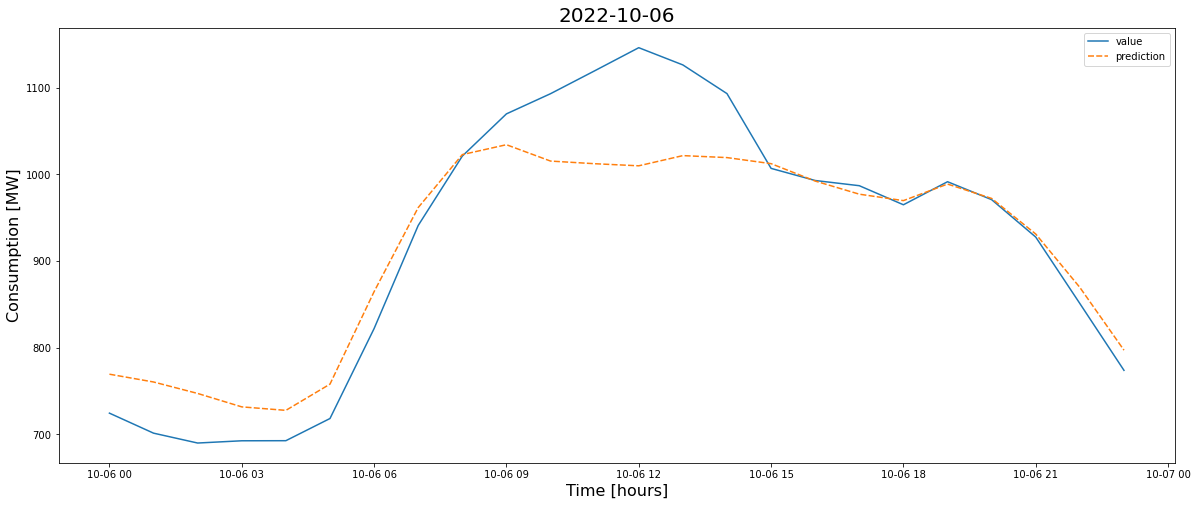

In [145]:
predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title(predict_for_start.date(), fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions_vector)*100))

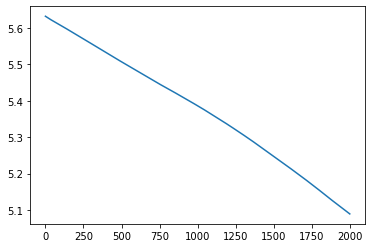

In [91]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();

## Random Forest

In [130]:
testing_vector = consumption[(consumption.index >= predict_for_start) &  (consumption.index < predict_for_end)]
training_vector = consumption[(consumption.index >= training_start) &  (consumption.index < training_end)]
validation_vector = consumption[(consumption.index >= validation_start) &  (consumption.index < validation_end)]


X_test = testing_vector[['lag7','lag2']]
y_test = testing_vector[['value']]

X_valid = validation_vector[['lag7','lag2']]
y_valid = validation_vector[['value']]

X_train = training_vector[['lag7','lag2']]
y_train = training_vector[['value']]

In [134]:
testing_vector = consumption[(consumption.index >= predict_for_start) &  (consumption.index < predict_for_end)]
training_vector = consumption[(consumption.index >= training_start) &  (consumption.index < training_end)]
validation_vector = consumption[(consumption.index >= validation_start) &  (consumption.index < validation_end)]


X_test = testing_vector[['lag7','lag2','sin_wd','cos_wd','sin_h','cos_h','T']]
y_test = testing_vector[['value']]

X_valid = validation_vector[['lag7','lag2','sin_wd','cos_wd','sin_h','cos_h','T']]
y_valid = validation_vector[['value']]

X_train = training_vector[['lag7','lag2','sin_wd','cos_wd','sin_h','cos_h','T']]
y_train = training_vector[['value']]

In [135]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 15)
rf.fit(X_train, y_train);


MAPE: 4.501


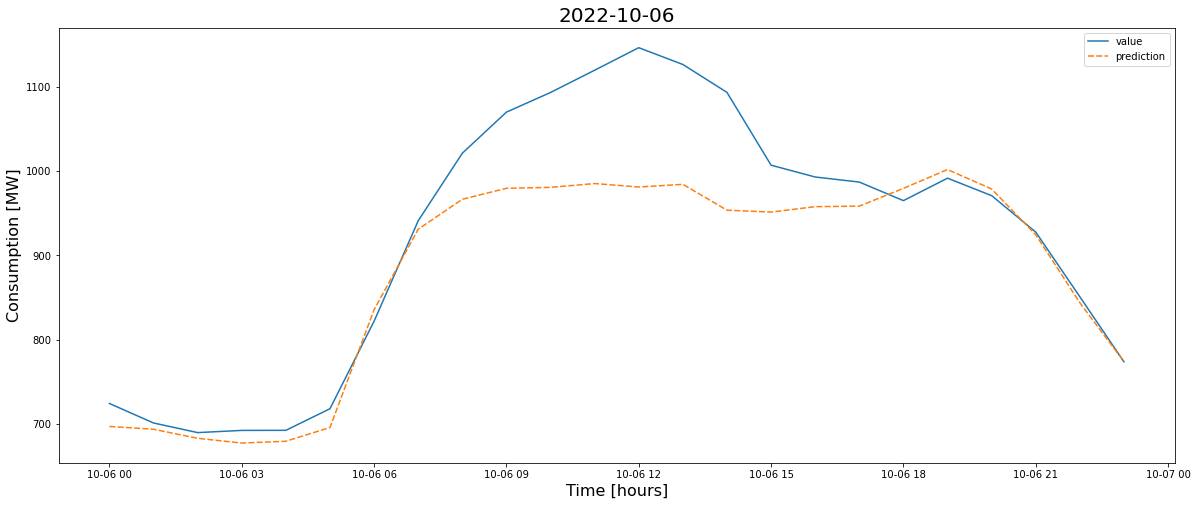

In [136]:
predictions_vector =  pd.DataFrame(rf.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title(predict_for_start.date(), fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions_vector)*100))

In [137]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
feature_list = X_train.columns
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: lag7                 Importance: 0.87
Variable: lag2                 Importance: 0.06
Variable: T                    Importance: 0.04
Variable: sin_wd               Importance: 0.01
Variable: cos_wd               Importance: 0.01
Variable: sin_h                Importance: 0.01
Variable: cos_h                Importance: 0.01


https://digikogu.taltech.ee/et/Item/9f92aabd-d5bd-4d9b-9525-5bfee3bd4727


https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting

https://www.tensorflow.org/tutorials/structured_data/time_series